# Credit Card Fraud Detection

The dataset contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. the only features which have not been transformed with PCA are 'Time' and 'Amount'. 

In general with highly imbalanced datasets there are several ways to approach building a well performing model.
- Undersample the data to balance the target class
- Oversample the minority class using a technique such as SMOTE (Synthetic Minority Over-Sampling)
- Collect more data
- Try penalized models
- Utilize different performance metrics (other than accuracy)
- Get creative


In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import collections
from tqdm import tqdm, tqdm_notebook

# PyTorch Packages
import torch.nn as nn
from torch.autograd import Variable as V
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader

# SKLearn Packages
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score)
from sklearn.metrics import accuracy_score, precision_score

# Plotting packages
import matplotlib.pyplot as plt
%matplotlib inline
from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
from bokeh.models import HoverTool, NumeralTickFormatter
from bokeh.palettes import Set3_12
from bokeh.transform import jitter
from bokeh.io import export_svgs
from bokeh.embed import components

import warnings
warnings.filterwarnings(action='ignore')

In [76]:
output_notebook()

Loading BokehJS ...

## Approach

The general approach to this notebook is based of this awesome [post.](https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd) However, this implementation utilizes Pytorch and there are several modifications the architecture and input data. 

This notebook evaluates using an autoencoder for anomaly and fraud detection. Autoencoders aren't new to machine learning, however they are not talked about as much as some of the newer techniques in deep learning. Autoencoders goal is to compress an input and then reconstruct the original input from the compressed data. 

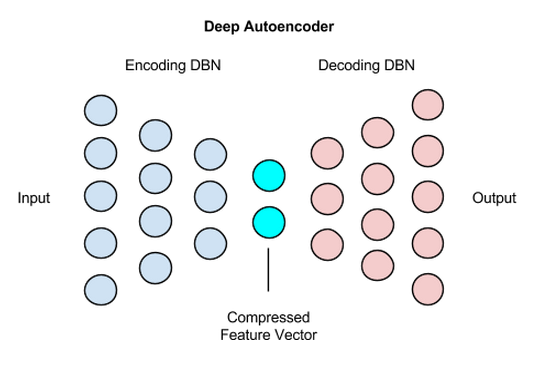

It is an unsupervised algorithm since the target variable is the input. There are many use cases and intresting applications of autoencoders which can be seen [here](https://towardsdatascience.com/autoencoders-bits-and-bytes-of-deep-learning-eaba376f23ad).

In the case of detecting fraud, the approach is to build a model that will learn the characteristics of a normal transaction by training the model only on non-fraudulent data points. The idea is to get the model as accurate as possible in recreating normal transaction from the filtered data set. Once you have a model that can recreate normal transaction with a given amount of error, you then use the model to predict a set of data that has both normal and fraudulent transaction. If everything goes well, you will have a model that given a normal transaction will predict the original inputs with a small margin of error and a much larger error for transactions that are fraudulent. 

In [77]:
df = pd.read_pickle('/home/jdoz/data/fraud.pkl')

Since the *time* column comes in as seconds from the start of the 2 day period. I first normalized the time to a normal 24 hour clock, then the time of every transaction and the amount to see if there is any pattern in the timing of fraudulent charges. For this notebook I will be using a mix of Bokeh and Seaborn for visualization.

In [78]:
df['TimeNorm'] = df['Time'].apply(lambda x: np.ceil(float(x)/3600) % 24.)

In [79]:
def format_plot(p, x_label, y_label):
    p.grid.grid_line_color = None
    p.background_fill_color = None
    p.border_fill_color = None
    p.outline_line_color = None
    p.axis.minor_tick_line_color = None
    p.title.align = "center"
    p.title.text_font_size = "22px"
    p.xaxis.axis_label = x_label
    p.yaxis.axis_label = y_label
    p.xaxis.axis_label_text_font_size = "18px"
    p.yaxis.axis_label_text_font_size = "18px"
    p.yaxis.axis_line_color = None
    p.yaxis.major_tick_line_color = None
    p.axis.major_label_text_font_size = "14px"
    p.title.text_font = "helvetica"
    p.xaxis.axis_label_text_font = "helvetica"
    p.yaxis.axis_label_text_font = "helvetica"
    p.axis.major_label_text_font = "helvetica"
    return p

In [80]:
# Get only fraud transactions
fraud_df = df[df["Class"] == 1]
f_source = ColumnDataSource(
    data=dict(x=fraud_df["TimeNorm"].values, y=fraud_df["Amount"].values)
)
# get 2% of only normal transactions
non_fraud_df = df[df["Class"] == 0].sample(frac=0.02)
norm_source = ColumnDataSource(
    data=dict(x=non_fraud_df["TimeNorm"].values, y=non_fraud_df["Amount"].values)
)
# create Bokeh figure
p = figure(
    plot_width=900,
    plot_height=500,
    toolbar_location=None,
    title="Transactions by Time and Amount",
)

# plot Normal Transactions
p.circle(
    x=jitter("x", width=0.9, range=p.x_range),
    y="y",
    color=Set3_12[4],
    fill_alpha=0.1,
    source=norm_source,
)

# plot fraud transactions
p.circle(
    x=jitter("x", width=0.9, range=p.x_range),
    y="y",
    color=Set3_12[3],
    fill_alpha=0.7,
    source=f_source,
)

# function to format plot
p = format_plot(p, "Time", "Amount")

p.yaxis[0].formatter = NumeralTickFormatter(format="$0,0")

show(p)

In [81]:
df.loc[df['Class'] == 1, 'Amount'].max()

2125.87

From the chart above it appears that there is no clear time window when fraud occurs more frequently. You can also see that all fraudulent charges fall below $2,126. While there may not be a lot of information gained by a visual inspection of time, I decided to leave it in the dataset as there may be some interactions with other variables that help detect these charges.

### Data Normalization

Next I normalized the time and amount variables to ease with model learning, then split the data into a training and testing dataset.

In [82]:
scl = StandardScaler()
df["TimeNorm"] = scl.fit_transform(df["TimeNorm"].values.reshape(-1, 1))
scl = StandardScaler()
df["NormAmt"] = scl.fit_transform(df["Amount"].values.reshape(-1, 1))

In [83]:
df = df.drop(['Time', 'Amount'], axis = 1)

In [84]:
x_train, x_test = train_test_split(df, test_size=0.2, random_state=42)

Since we are training an autoencoder that will learn the features of a normal transaction, we filter the training set to remove all transactions that were fraudulent from the training set however we leave the test set as is, containing both types of transactions.

In [85]:
x_train = x_train[x_train["Class"] == 0]
x_train = x_train.drop("Class", axis=1)

y_test = x_test["Class"].values
x_test = x_test.drop("Class", axis=1)
x_test = x_test.values
x_train = x_train.values

x_train.shape, x_test.shape

((227451, 30), (56962, 30))

Next you have to transform the numpy arrays as a pytorch Float Tensor and load them into a DataLoader object. The dataloader is a generator that feeds the data to the training loop at the specified batch size.

In [86]:
xt = torch.FloatTensor(x_train).cuda()
xtr = torch.FloatTensor(x_test).cuda()

xdl = DataLoader(xt, batch_size=50000)
tdl = DataLoader(xtr, batch_size=50000)

### Autoencoder Model

The architecture of the autoencoder consist of 4 fully connected layers starting at input size of 30 (30 variables) reducing down to 10 and then decoding back up to 30. 

In [95]:
class Net1(nn.Module):
    def __init__(self, drops=[0.1, 0.05, 0.01]):
        super().__init__()
        self.lin1 = nn.Linear(30, 20)
        self.lin2 = nn.Linear(20, 10)
        self.lin3 = nn.Linear(10, 20)
        self.lin4 = nn.Linear(20, 30)
        self.drop1 = nn.Dropout(drops[0])
        self.drop2 = nn.Dropout(drops[1])
        self.drop3 = nn.Dropout(drops[2])

    def forward(self, data):
        x = self.drop1(torch.relu(self.lin1(data)))
        x = self.drop2(torch.relu(self.lin2(x)))
        x = self.drop3(torch.tanh(self.lin3(x)))
        x = self.lin4(x)

        return x

This function utilizes the model's loss function to calculate the loss for the validation test set. In this instance of using an autoencoder for anomaly detection the validation score doesnt really mean much since it will have both fraud and non fraud scores. What we really care about is having the model learn as much as it can about what a normal transaction looks like. 

In [96]:
def score(x):
    y_pred = model(V(x).cuda())
    x1 = V(x).cuda()
    return loss(y_pred,x1).item()

Next is the training loop. This function takes in the number of epochs the model that you wish to train as well as a model_loss variable that is used to keep the history (model and validation loss) at each epoch. This is a fairly standard pytorch training loop except that instead of taking in an X and a Y variable it takes in X from the dataloader gets the prediction from the model and determines the loss between the original X and the model prediction. It then goes on to change the gradients through back propogation based on the determined loss.

In [113]:
def train(epochs, model, model_loss):
    try:
        c = model_loss.epoch[-1]
    except:
        c = 0
    for epoch in tqdm_notebook(range(epochs), position=0, total=epochs):
        losses = []
        dl = iter(xdl)
        for t in range(len(dl)):
            # Forward pass: compute predicted y and loss by passing x to the model.
            xt = next(dl)
            y_pred = model(V(xt).cuda())

            l = loss(y_pred, V(xt).cuda())
            losses.append(l)
            optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to model parameters
            l.backward()

            # Calling the step function on an Optimizer makes an update to its parameters
            optimizer.step()

        val_dl = iter(tdl)
        val_scores = [score(next(val_dl)) for i in range(len(val_dl))]

        model_loss.epoch.append(c + epoch)
        model_loss.loss.append(l.item())
        model_loss.val_loss.append(np.mean(val_scores))
        texts = ["Epoch: ","Loss: ","Val Loss: "]
        vals = [epoch, l.item(), np.mean(val_scores)]
        print(" ".join([f'{x}{y:g}\t' for x,y in zip(texts, vals)]))

In [114]:
# Utilize a named tuple to keep track of scores at each epoch
model_hist = collections.namedtuple("Model", "epoch loss val_loss")
model_loss = model_hist(epoch=[], loss=[], val_loss=[])

### Model Training

With the Pytorch structure set up we can now train the model.

In [115]:
model = Net1([0.0, 0.0, 0.0, 0.0]).cuda()
loss = nn.MSELoss()
lr = 1e-01
wd = 0
optimizer = torch.optim.Adam(model.parameters(), weight_decay=wd, lr=lr)

In [116]:
train(model = model, epochs = 20,model_loss= model_loss)

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

Epoch: 0	 Loss: 0.890579	 Val Loss: 0.914069	
Epoch: 1	 Loss: 0.758914	 Val Loss: 0.780263	
Epoch: 2	 Loss: 0.688028	 Val Loss: 0.720524	
Epoch: 3	 Loss: 0.639675	 Val Loss: 0.728796	
Epoch: 4	 Loss: 0.675452	 Val Loss: 0.694037	
Epoch: 5	 Loss: 0.616264	 Val Loss: 0.661295	
Epoch: 6	 Loss: 0.582542	 Val Loss: 0.622261	
Epoch: 7	 Loss: 0.549569	 Val Loss: 0.588914	
Epoch: 8	 Loss: 0.524508	 Val Loss: 0.566192	
Epoch: 9	 Loss: 0.524787	 Val Loss: 0.566304	
Epoch: 10	 Loss: 0.50565	 Val Loss: 0.54415	
Epoch: 11	 Loss: 0.48247	 Val Loss: 0.514425	
Epoch: 12	 Loss: 0.512919	 Val Loss: 0.569702	
Epoch: 13	 Loss: 0.470364	 Val Loss: 0.512181	
Epoch: 14	 Loss: 0.449314	 Val Loss: 0.48215	
Epoch: 15	 Loss: 0.431402	 Val Loss: 0.476787	
Epoch: 16	 Loss: 0.458632	 Val Loss: 0.561089	
Epoch: 17	 Loss: 0.478992	 Val Loss: 0.511419	
Epoch: 18	 Loss: 0.443636	 Val Loss: 0.485733	
Epoch: 19	 Loss: 0.435866	 Val Loss: 0.479561	



In [120]:
lr = 1e-02
optimizer.param_groups[0]['lr'] = lr
train(model=model, epochs=20, model_loss=model_loss)

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

Epoch: 0	 Loss: 0.417067	 Val Loss: 0.458502	
Epoch: 1	 Loss: 0.412498	 Val Loss: 0.452444	
Epoch: 2	 Loss: 0.406388	 Val Loss: 0.446186	
Epoch: 3	 Loss: 0.403	 Val Loss: 0.441759	
Epoch: 4	 Loss: 0.400933	 Val Loss: 0.439304	
Epoch: 5	 Loss: 0.398345	 Val Loss: 0.437128	
Epoch: 6	 Loss: 0.396542	 Val Loss: 0.435195	
Epoch: 7	 Loss: 0.394921	 Val Loss: 0.433669	
Epoch: 8	 Loss: 0.393409	 Val Loss: 0.432249	
Epoch: 9	 Loss: 0.392105	 Val Loss: 0.430912	
Epoch: 10	 Loss: 0.390848	 Val Loss: 0.429653	
Epoch: 11	 Loss: 0.389618	 Val Loss: 0.428462	
Epoch: 12	 Loss: 0.388438	 Val Loss: 0.42728	
Epoch: 13	 Loss: 0.38725	 Val Loss: 0.42611	
Epoch: 14	 Loss: 0.386065	 Val Loss: 0.424939	
Epoch: 15	 Loss: 0.384883	 Val Loss: 0.423795	
Epoch: 16	 Loss: 0.383689	 Val Loss: 0.422621	
Epoch: 17	 Loss: 0.382473	 Val Loss: 0.421425	
Epoch: 18	 Loss: 0.38122	 Val Loss: 0.420189	
Epoch: 19	 Loss: 0.379935	 Val Loss: 0.418916	



In [121]:
lr = 1e-03
optimizer.param_groups[0]['lr'] = lr
train(model=model, epochs=30, model_loss=model_loss)

HBox(children=(IntProgress(value=0, max=30), HTML(value='')))

Epoch: 0	 Loss: 0.379547	 Val Loss: 0.418778	
Epoch: 1	 Loss: 0.3794	 Val Loss: 0.418641	
Epoch: 2	 Loss: 0.379258	 Val Loss: 0.418508	
Epoch: 3	 Loss: 0.379115	 Val Loss: 0.418373	
Epoch: 4	 Loss: 0.378973	 Val Loss: 0.418235	
Epoch: 5	 Loss: 0.378828	 Val Loss: 0.418092	
Epoch: 6	 Loss: 0.378679	 Val Loss: 0.417947	
Epoch: 7	 Loss: 0.37853	 Val Loss: 0.417802	
Epoch: 8	 Loss: 0.378378	 Val Loss: 0.417655	
Epoch: 9	 Loss: 0.378225	 Val Loss: 0.417507	
Epoch: 10	 Loss: 0.378069	 Val Loss: 0.417357	
Epoch: 11	 Loss: 0.377913	 Val Loss: 0.417205	
Epoch: 12	 Loss: 0.377754	 Val Loss: 0.417052	
Epoch: 13	 Loss: 0.377594	 Val Loss: 0.416898	
Epoch: 14	 Loss: 0.377433	 Val Loss: 0.416741	
Epoch: 15	 Loss: 0.377269	 Val Loss: 0.416583	
Epoch: 16	 Loss: 0.377104	 Val Loss: 0.416423	
Epoch: 17	 Loss: 0.376938	 Val Loss: 0.416262	
Epoch: 18	 Loss: 0.37677	 Val Loss: 0.416099	
Epoch: 19	 Loss: 0.3766	 Val Loss: 0.415935	
Epoch: 20	 Loss: 0.37643	 Val Loss: 0.41577	
Epoch: 21	 Loss: 0.376258	 Val 

### Training Evaluation

In [122]:
# Define a plot source
source = ColumnDataSource(data=dict(
    x=model_loss.epoch,
    loss=model_loss.loss,
    val_loss = model_loss.val_loss
))

p = figure(plot_height = 500, 
           plot_width = 900,
           toolbar_location = None, 
           title = "Model L1 Loss")

ml = p.line(x = "x", y = "loss", 
           color=Set3_12[4], 
           line_width = 3, 
            
           legend = "Training Loss", 
           source=source)

p.line(x = "x", y = "val_loss", 
       color=Set3_12[5], 
       line_width = 3, 
       legend = "Validation Loss",
       source=source)


tips = [
    ("Epoch","@x"),
    ("Model Loss","@loss{0.000}"),
    ("Val Loss","@val_loss{0.000}")
]
p.add_tools(HoverTool(tooltips=tips, 
                      renderers= [ml], 
                      mode='vline'))


p = format_plot(p, 'Epoch', 'Loss')

show(p)

From the chart above the model loss is still going down, there may have been some performance gains by running a few more epochs to allow the loss to flatten out. 

Now it is time to calculate the reconstruction error on the test set to see how well it predicts normal transactions vs fraud.

### Predictions

Next I utilize the trained model to make predicitons on the test set, which remember unlike the training set, the test set has fraudulent transactions. I feed in the test dataloader to the model to get predictions then calculate the reconstruction error. The amount of error between the original input and the model predicitons against the test set. The error for each row will be used to determine if each transaction is normal or fraud.

In [123]:
p = iter(tdl)
preds = np.vstack([model(V(next(p))).cpu().data.numpy() for i in range(len(p))])

In [124]:
# error = np.mean(abs(x_test - preds), axis = 1)
error = np.mean(np.power((x_test - preds),2), axis = 1)
error_df = pd.DataFrame(data = {'error':error,'true':y_test})

error_df.groupby('true')['error'].describe().reset_index()

,true,count,mean,std,min,25%,50%,75%,max
0,0,56864.0,0.366284,1.298072,0.031300,0.162475,0.243017,0.377830,105.741639
1,1,98.0,24.115782,33.614115,0.147024,3.784406,9.037388,43.580015,193.935995


By stacking the error on the test set next to the actual target value (1,0) for ease of use I created a pandas DataFrame and grouped the data by the two types of transactions. 
From the summary table above we can see in fact that the statistics for the two groups do look quite different. However we will have to evaluate further to see if they are in fact different enough for accurate final predictions. I started by looking at the ROC AUC.

In [125]:
fpr, tpr, thresholds = roc_curve(error_df.true, error_df.error)
roc_auc = auc(fpr, tpr)

source = ColumnDataSource(data=dict(
    fpr = fpr,
    tpr = tpr,
    x = np.linspace(0,1,len(fpr)),
    y = np.linspace(0,1,len(fpr))
))

p = figure(plot_height = 500, plot_width = 500,
           toolbar_location = None, 
           title = "Receiver Operating Characteristic")

j = p.line(x = "x", y = "y", 
           color=Set3_12[3], 
           line_width = 3, 
           line_dash = 'dashed', 
           source=source)

k = p.line(x = "fpr", y = "tpr", 
           color=Set3_12[4], 
           line_width = 3, 
           legend = f'AUC = {roc_auc:0.4f}',
           source=source)

tips= [
    ("False-Pos", "@fpr{00.0%}"),
    ("True-Pos", "@tpr{00.0%}"),
    ]
p.add_tools(HoverTool(tooltips=tips, renderers=[k], mode='vline'))

p = format_plot(p, 'False Positive Rate', 'True Positive Rate')
p.legend.location = 'bottom_right'

# script, div = components(p)
show(p)

### Model Perfomance

The ROC AUC plots the False Positive Rate against the True Positive rate. The dashed red line represents a random guess of a 50/50 chance of predicting the correct outcome. Ideally the ROC line would fit perfectly in the upper left hand corner which would represent a perfect model. While the ROC AUC is generally a good thing to use to check model performance it only looks at 2 of the possible 4 outcomes of binary classification. False Negatives and True negatives are not directly observed in this plot. To get the rest of the story it is necessary to look at the confusion matrix.

When performing binary classification there are 4 types of outcomes:

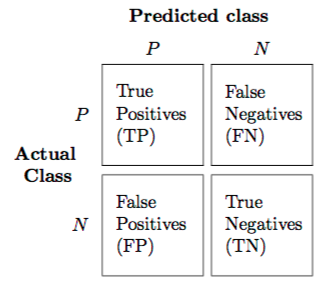

In the case of this dataset:
* ***True Positive:*** The number of normal transactions did we correctly predict as normal
* ***False Negatives:*** The number of normal transactions that the model incorrectly classifies as fraud
* ***False Positives:*** The number of fraudulent transactions the model incorrectly classifies as normal
* ***True Negatives:*** The number of fraudlent transactions the model accurately classifies as fraud

Since our predictions are based on the error between the original and predicted values of the input, it is necessary to find a cut off point in the error where anything above a threshold is considered fraud and anything below we consider it to be a normal transaction. To start I decided to set the threshold as the sum of the mean and standard deviation of the error of the normal transactions.

In [126]:
temp_df = error_df[error_df["true"] == 0]
threshold = temp_df["error"].mean() + temp_df["error"].std()
print(f"Threshold: {threshold:.3f}")

Threshold: 1.664


In [127]:
y_pred = [1 if e > threshold else 0 for e in error_df.error.values]
print(classification_report(error_df.true.values, y_pred))

             precision    recall  f1-score   support

          0       1.00      0.99      0.99     56864
          1       0.11      0.87      0.20        98

avg / total       1.00      0.99      0.99     56962



Above is the classification report however I found these metrics to be a bit decieving and hard to conceptualize. I found that in the case of this unbalanced dataset it is easier to understand by looking at the actual values for number of fraudulent transactions missed and number of normal transactions that were miss classified in the confusion matrix.

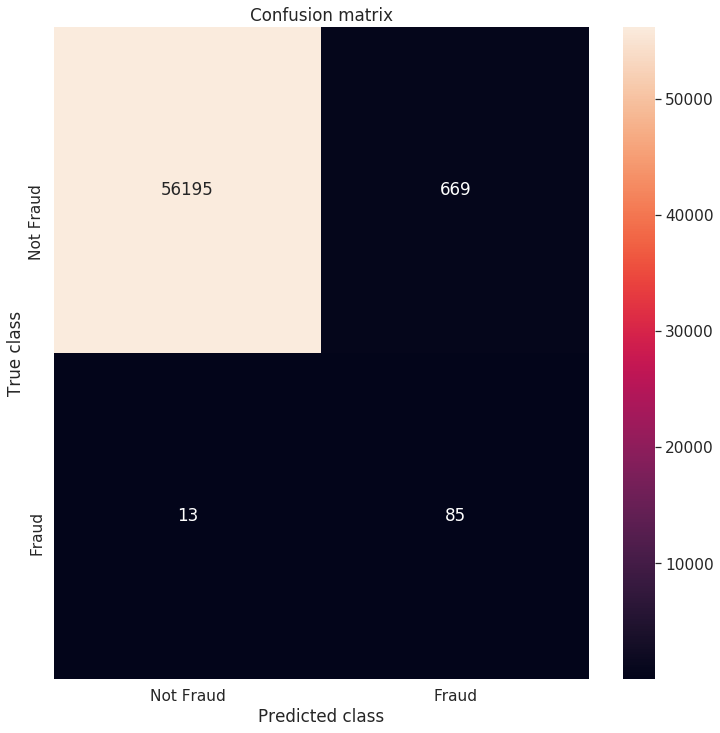

In [129]:
conf_matrix = confusion_matrix(error_df.true, y_pred)

sns.set(font_scale=1.4)
plt.figure(figsize=(12, 12))
sns.heatmap(
    conf_matrix,
    xticklabels=["Not Fraud", "Fraud"],
    yticklabels=["Not Fraud", "Fraud"],
    annot=True,
    fmt="g",
)
plt.title("Confusion matrix")
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.show()

At first look, the model seems to catch all but around 9% of the fraudulent transactions, however at that threshold te model incorrectly identifies around 4000 normal transactions as fraud (False Negatives). 

This is where the benefit of having a threshold pay off. It allows the flexibility of determining the amount of normal transactions you are willing to accept in order to catch the targeted amount of Fraud. The False Negatives and False Positives have inverse behaivor, as the amount of missed fraudulent transactions decrease, the normal transactions that are incorrectly predicted as fraud increase.

Next I iterated through a range of thresholds and plotted to confusion matrix at each threshold to get a better idea of what the decision space looks like.

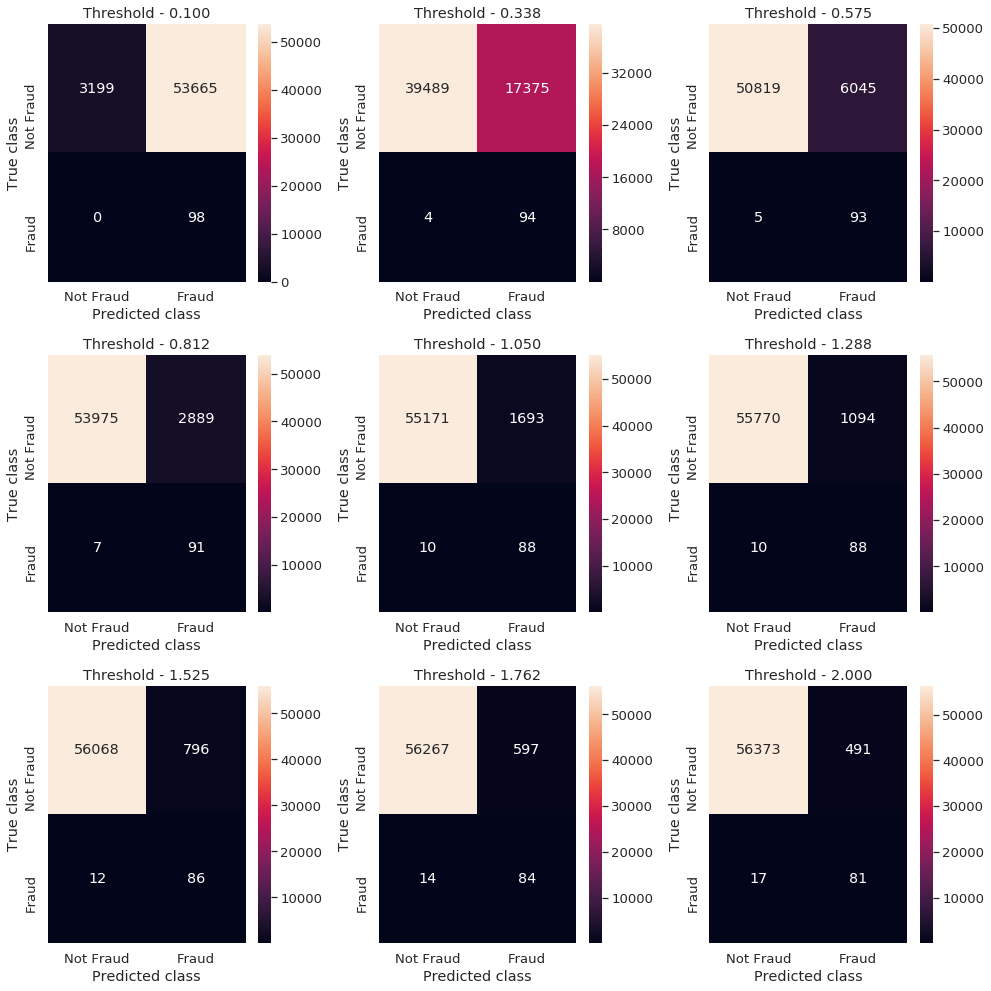

In [131]:
plt.figure(figsize=(14, 14))
sns.set(font_scale=1.2)
m = []
for thresh in np.linspace(0.1, 2, 9):
    y_pred = [1 if e > thresh else 0 for e in error_df.error.values]
    conf_matrix = confusion_matrix(error_df.true, y_pred)
    m.append((conf_matrix, thresh))

count = 0
for i in range(3):
    for j in range(3):
        plt.subplot2grid((3, 3), (i, j))
        sns.heatmap(
            m[count][0],
            xticklabels=["Not Fraud", "Fraud"],
            yticklabels=["Not Fraud", "Fraud"],
            annot=True,
            fmt="d",
        )
        plt.title(f"Threshold - {m[count][1]:.3f}")
        plt.ylabel("True class")
        plt.xlabel("Predicted class")
        plt.tight_layout()
        count += 1
plt.show()

In [132]:
thr = []
tp = []
fn = []
fp = []
tn = []
for thresh in np.linspace(0.1, 3, 200):
    y_pred = [1 if e > thresh else 0 for e in error_df.error.values]
    conf = confusion_matrix(error_df.true, y_pred)
    tp.append(conf[0][0])
    fp.append(conf[0][1])
    fn.append(conf[1][0])
    tn.append(conf[1][1])
    thr.append(thresh)

In [133]:
conf_df = pd.DataFrame(data={"fp": fp, "fn": fn, "threshold": thr})
cdf = conf_df.drop_duplicates(subset="fn", keep="last")
print(cdf)

        fp  fn  threshold
3    46253   0   0.143719
5    40619   1   0.172864
9    30198   2   0.231156
15   19178   3   0.318593
26    8894   4   0.478894
33    5908   5   0.580905
44    3472   6   0.741206
50    2800   7   0.828643
60    2005   9   0.974372
87     969  10   1.367839
92     891  11   1.440704
101    737  12   1.571859
111    622  13   1.717588
115    589  14   1.775879
120    557  15   1.848744
123    539  16   1.892462
139    445  17   2.125628
146    416  18   2.227638
175    320  19   2.650251
199    265  20   3.000000


In [134]:
xx = [str(x) for x in cdf["fn"].values]
source = ColumnDataSource(data=dict(fn=xx, fp=cdf["fp"].values))

p = figure(
    plot_width=900,
    plot_height=500,
    toolbar_location=None,
    x_range=xx,
    title="False Negative vs False Positive",
)

p.vbar(x="fn", top="fp", width=0.9, color=Set3_12[3], source=source)

# tips= [
#     ("False-Pos", "@fpr{00.0%}"),
#     ("True-Pos", "@tpr{00.0%}"),
#     ]
# p.add_tools(HoverTool(tooltips=tips, renderers=[k], mode='vline'))

p = format_plot(p, "False Negatives", "False Positive")
# p.legend.location = 'bottom_right'
show(p);

In the plot above you can see the tradespace for a given reconstruction error threshold. There is a large dropoff after 2 False Negatives. Ideally this plot would be in percentages to show overall model performance, since these numbers would change depending on your test set size. However actual number of fraudlent transactions is a bit more intuitive.

### Conclusion and Further Work

Since the data we were given came is the principal components it is difficult to fully understand the values of each of the model inputs. In this notebook I did not attempt to do any feature engineering or general dimensionality reduction (although the autoencoder does) to try to improve the model.

In general the model performs well however there are still a small number of fraudulent transactions that can't be cleanly seperated from normal transactions, but the model provides a decision space to do tradeoff analysis and determine the best threshold given how much a fraudulent transactions cost the business vs how much it cost the business to incorrectly label normal transactions (difficult to quantify).

Next, I would like to look into ensembling this with other models as well as taking the weights of the pretrained autoencoder and using additonal layers to perform the final binary classification. 

Thanks for reading.